# STDP Learning rule

In [1]:
import numpy as np
from pymonntorch import *
import torch

import matplotlib.pyplot as plt

from models.activity import ActivityRecorder
from models.dendrites import Dendrite
from models.currents import ConstantCurrent, NoisyCurrent, SetCurrent, CurrentSum
from models.encoders import TimeToFirstSpikeEncoder, NumberEncoder, PoissonEncoder, FeedDataset
from models.learnings import STDP
from models.neurons import LIF
from models.synapses import SimpleSynapse, FullyConnectedSynapse, RandomConnectedFixedProbSynapse, \
    RandomConnectedFixedInputSynapse
from models.time_res import TimeResolution
from simulate import Simulation
from utils.images import CustomImage


## STDP on array

In [2]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((torch.randperm(50), np.ones(50))),
                                          np.concatenate((np.ones(50), 2*torch.randperm(50)))],
                                 duration=25,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

/home/amir/Documents/university/Semester 8/Neuroscience/hw3/models/encoders.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.dataset = torch.tensor(self.dataset)


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37d9599e90>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


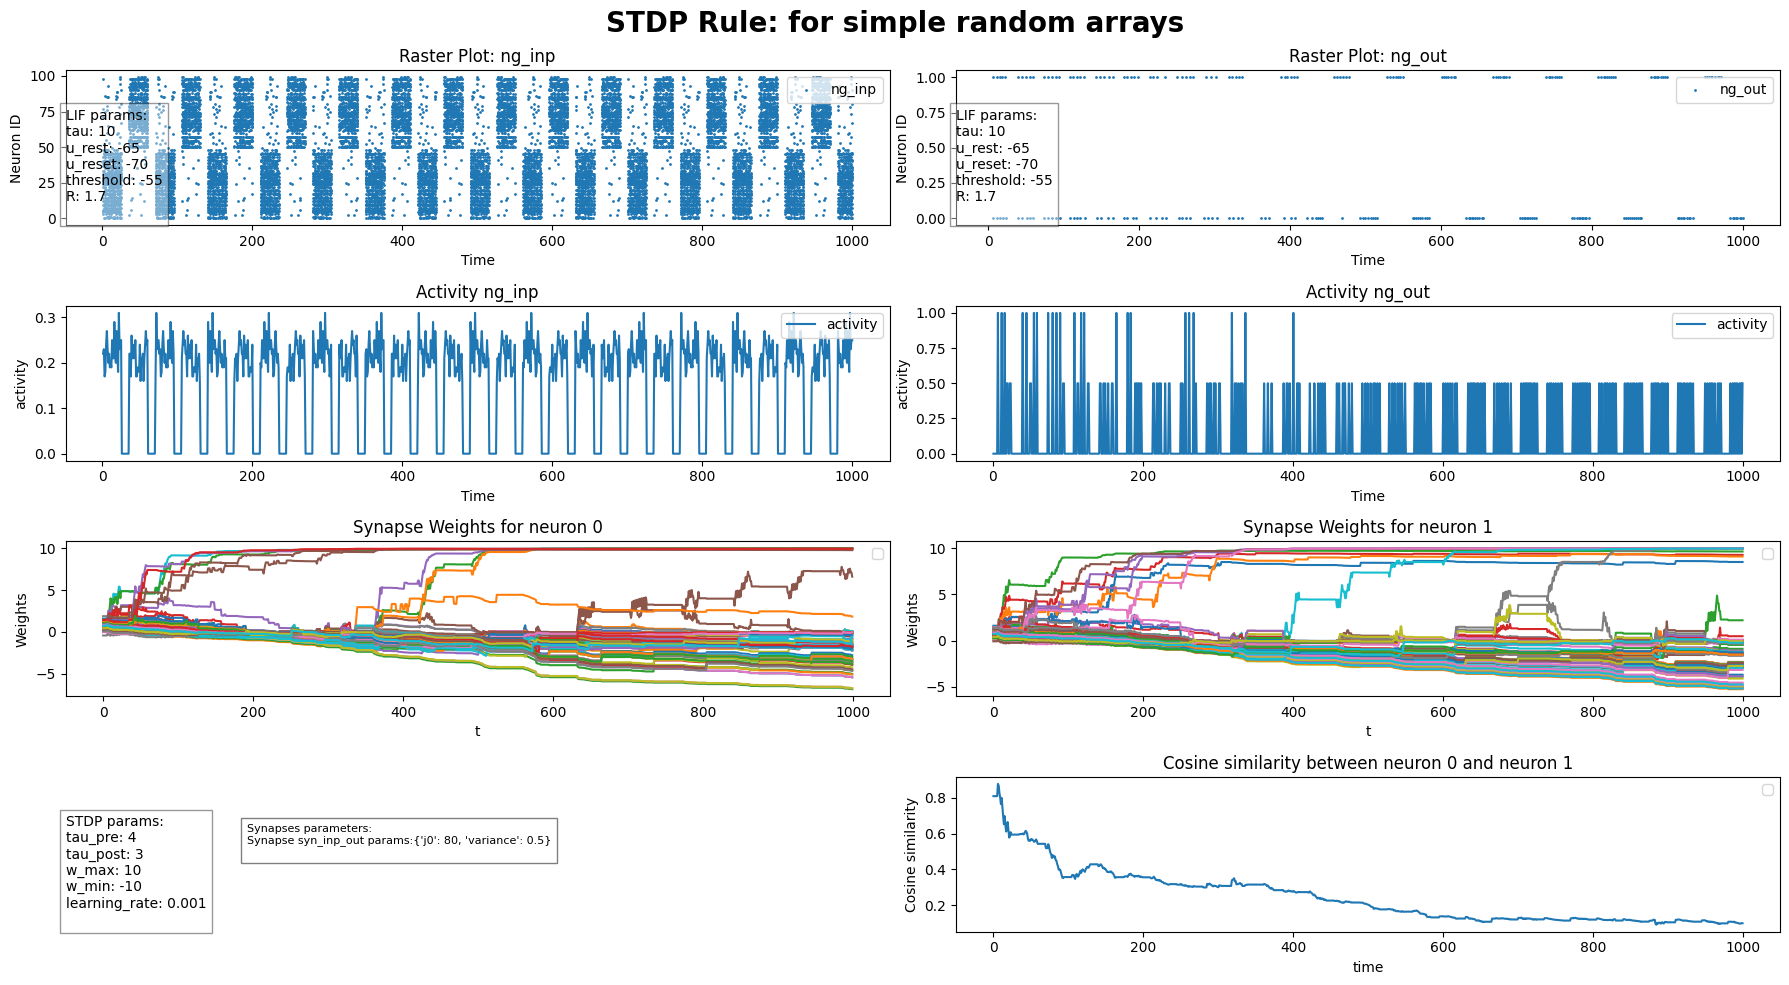

In [3]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("STDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

## Increase the size of input

In [4]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((torch.randperm(100), np.ones(100))),
                                          np.concatenate((np.ones(100), 2*torch.randperm(100)))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=200,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(202)|2 groups, Synapses: tensor(400)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37dad74e50>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


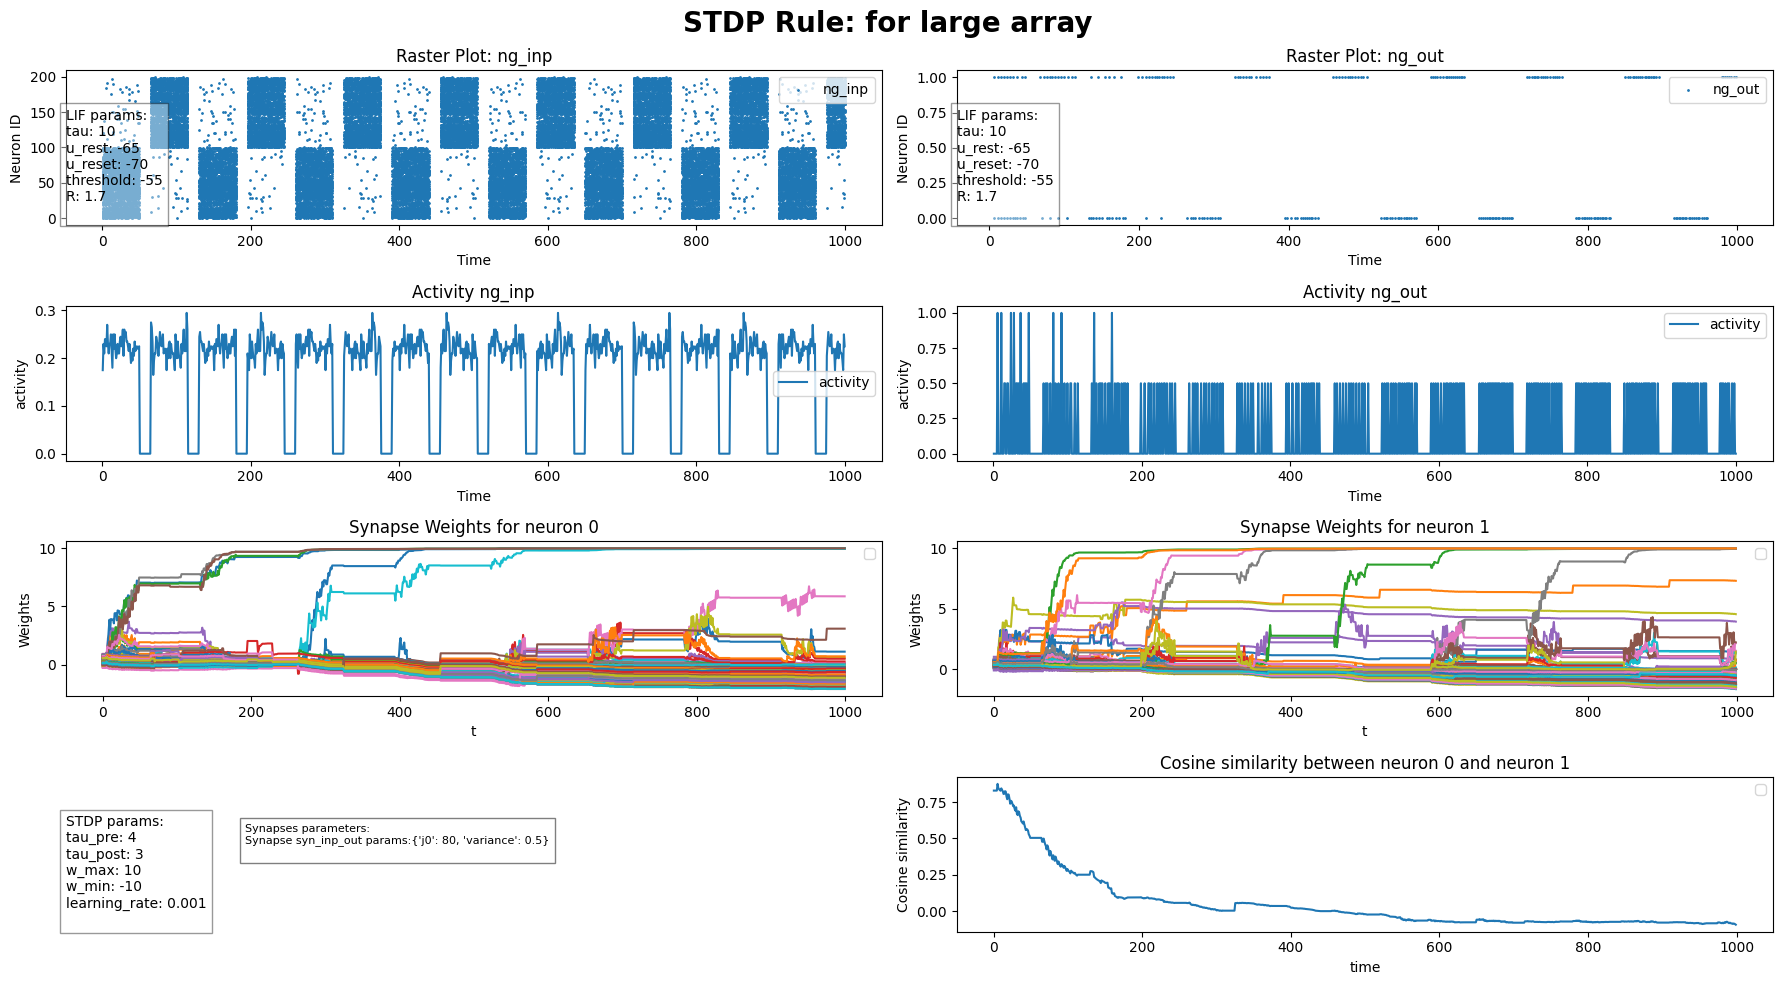

In [5]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: for large array", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

## Feed input such that have common neurons

In [6]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((torch.randperm(100), np.ones(50))),
                                          np.concatenate((np.ones(50), 2*torch.randperm(100)))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37d58e7a50>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


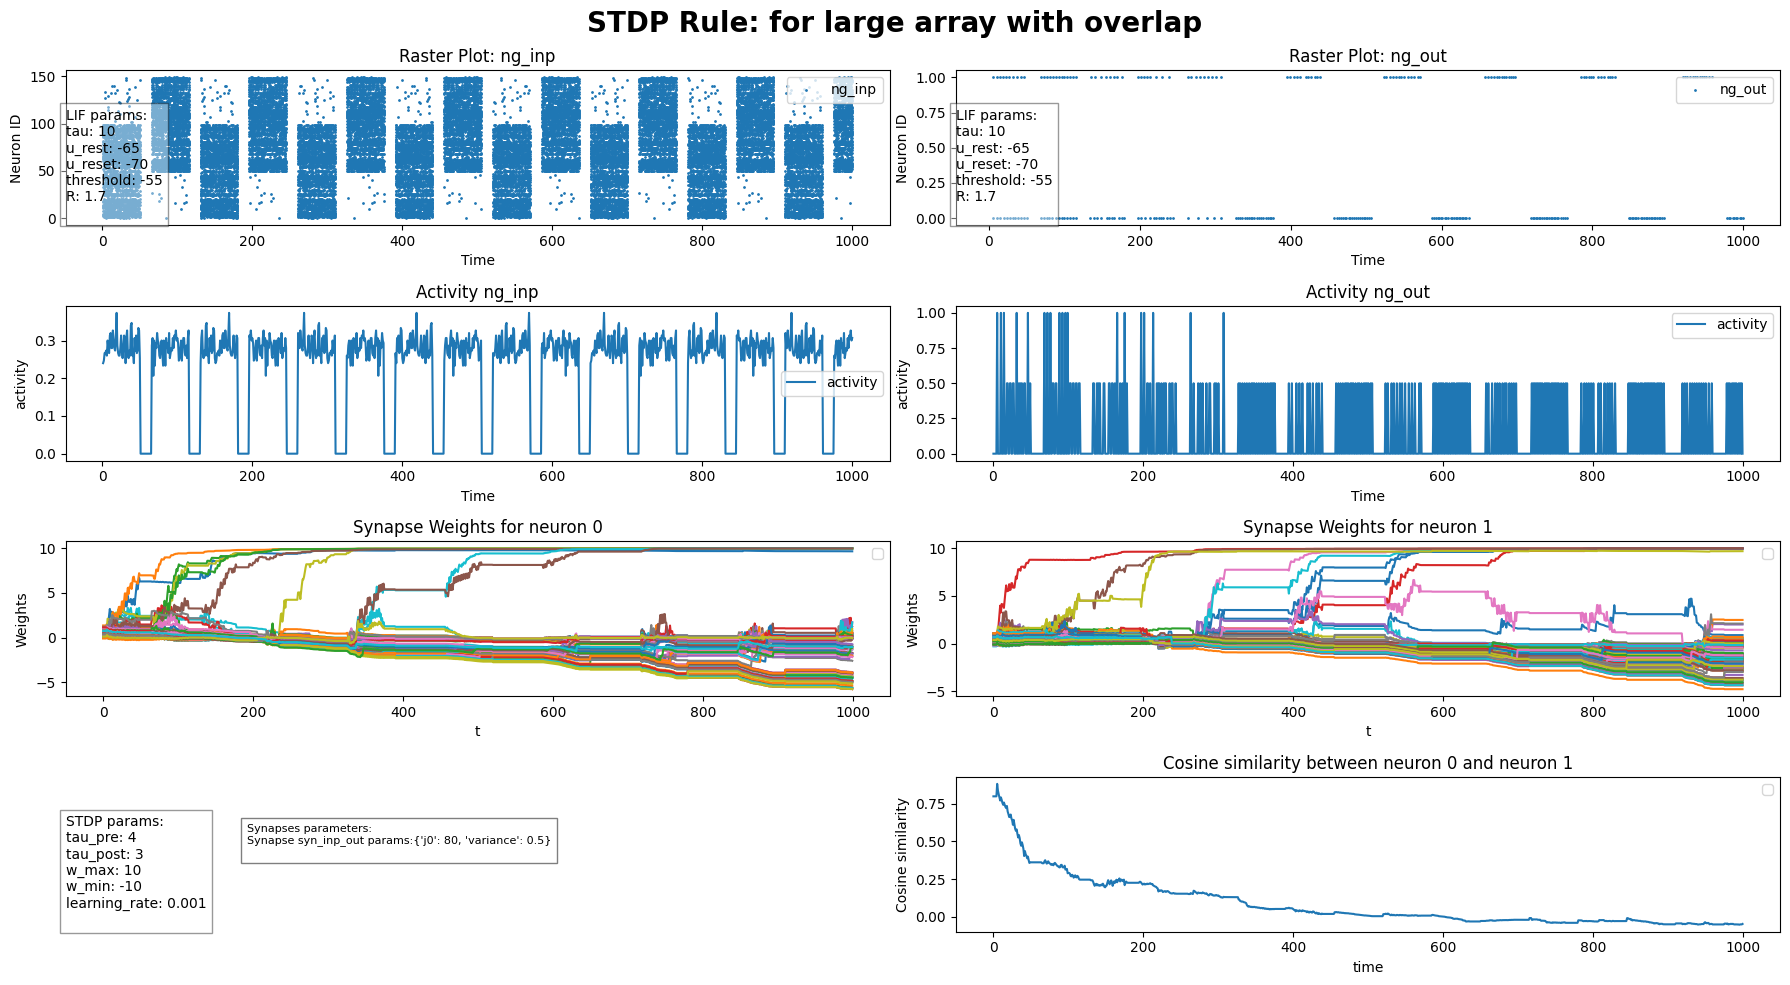

In [7]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: for large array with overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-array-stdp-overlap.pdf")
plt.show()

### Completely overlapped

In [33]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.array(torch.randperm(100)),
                                          np.array(torch.randperm(100))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37bd6e4650>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


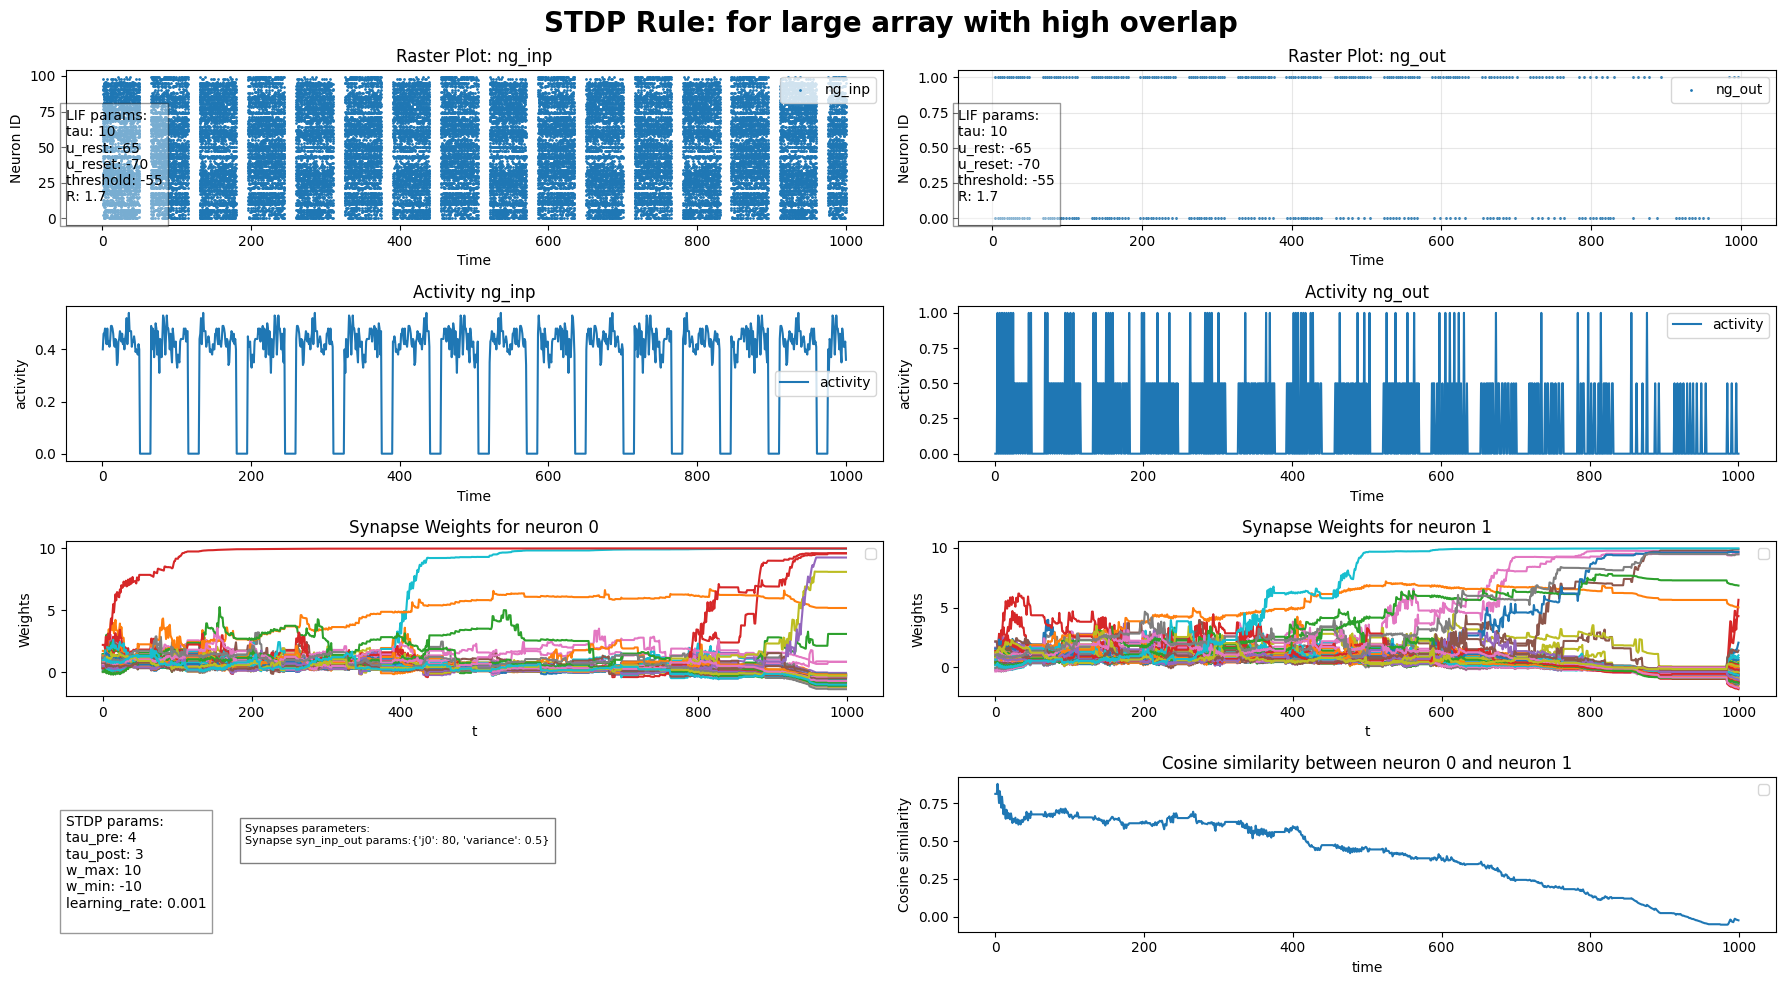

In [34]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: for large array with high overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-array-stdp-high-overlap.pdf")
plt.show()

## Use simple patterns

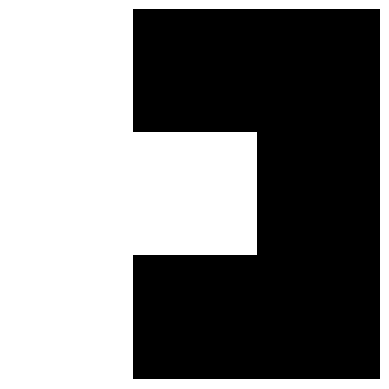

In [10]:
img1 = CustomImage('dataset/pattern1.png')
img1.img_show()

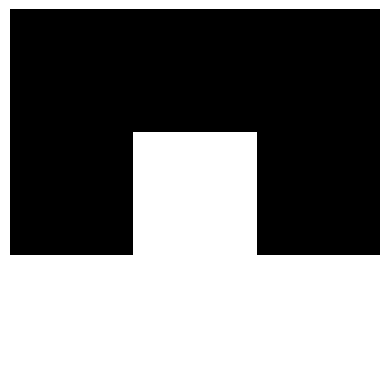

In [11]:
img2 = CustomImage('dataset/pattern2.png')
img2.img_show()

In [12]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.ones(9))),
                                          np.concatenate((np.ones(9), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=18,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=50,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](18){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37bd541bd0>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=Non

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


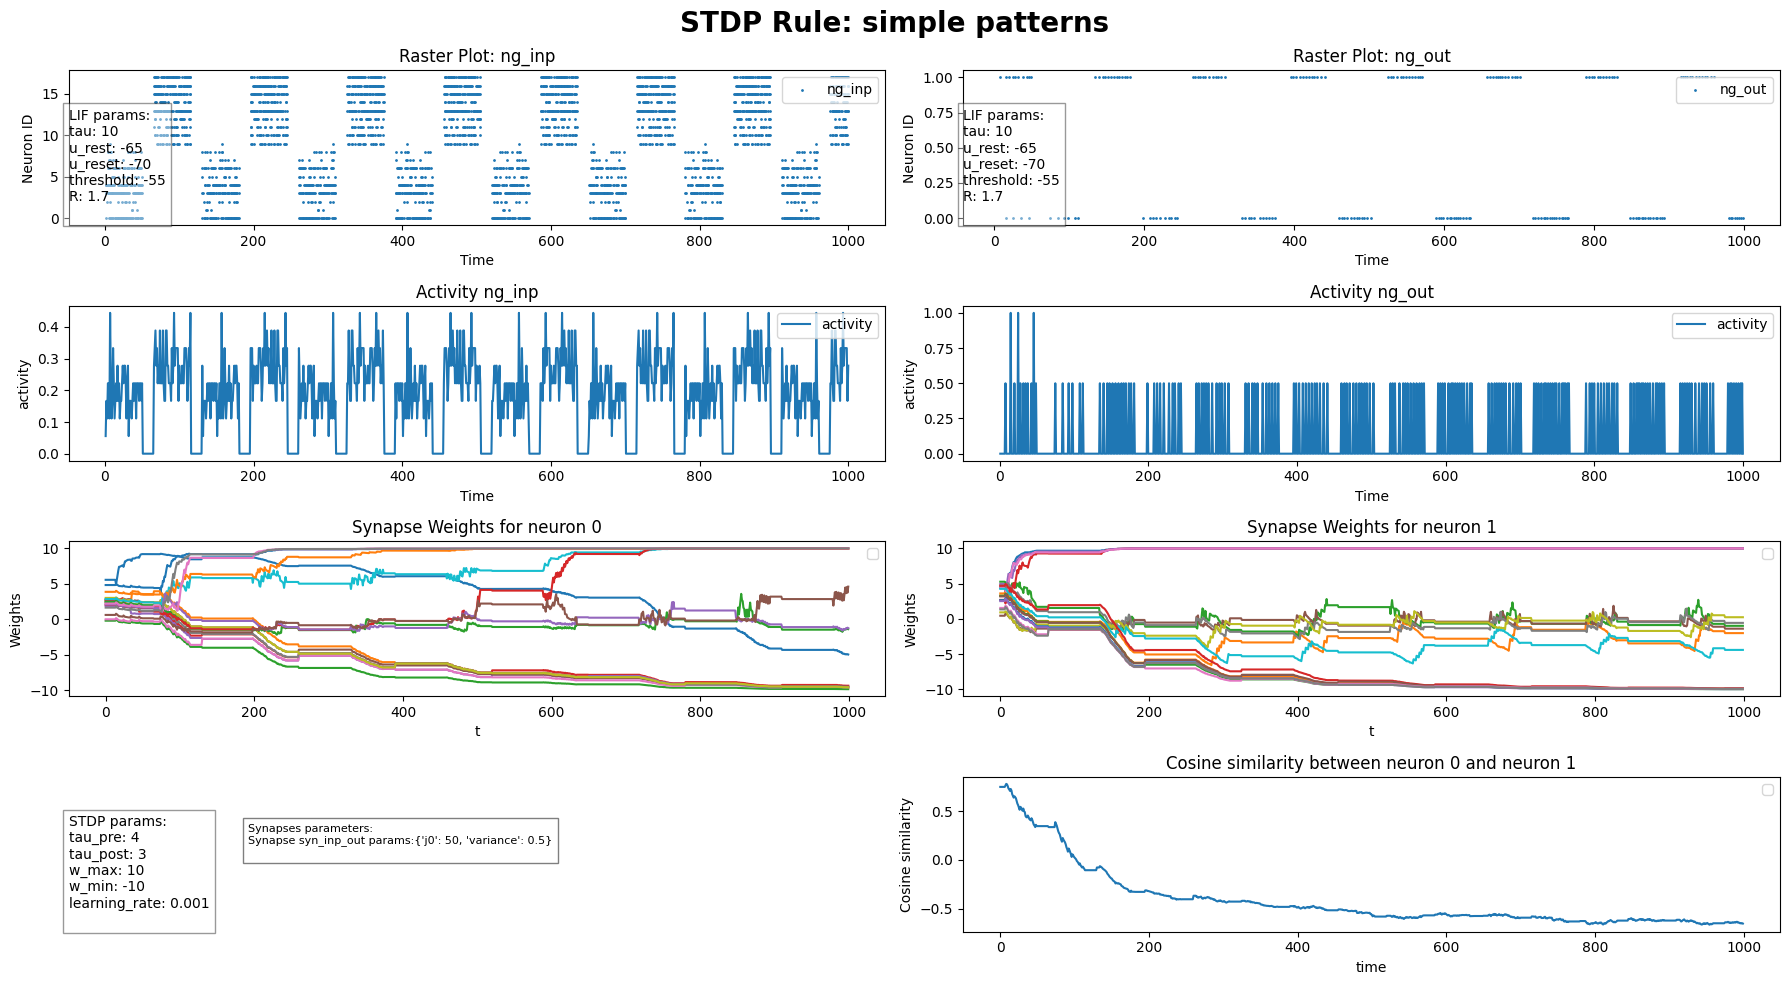

In [13]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: simple patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-pattern-stdp.pdf")
plt.show()

## Use image as dataset

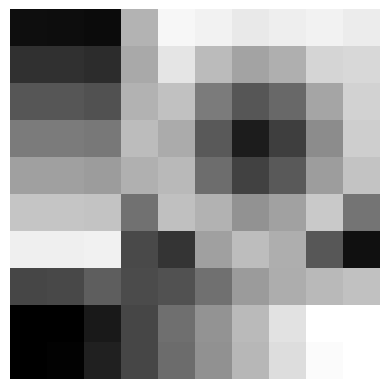

In [14]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(10, 10)
img1.img_show()

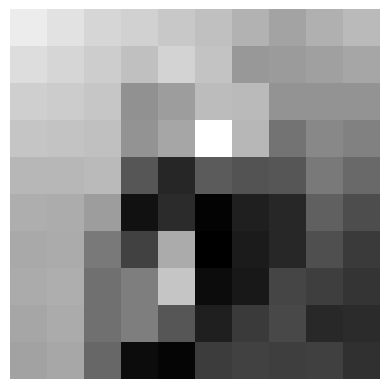

In [15]:
img2 = CustomImage('dataset/bird.tif')
img2.resize_image(10, 10)
img2.img_show()

In [16]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.ones(100))),
                                          np.concatenate((np.ones(100), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=200,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(202)|2 groups, Synapses: tensor(400)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37bcb97490>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


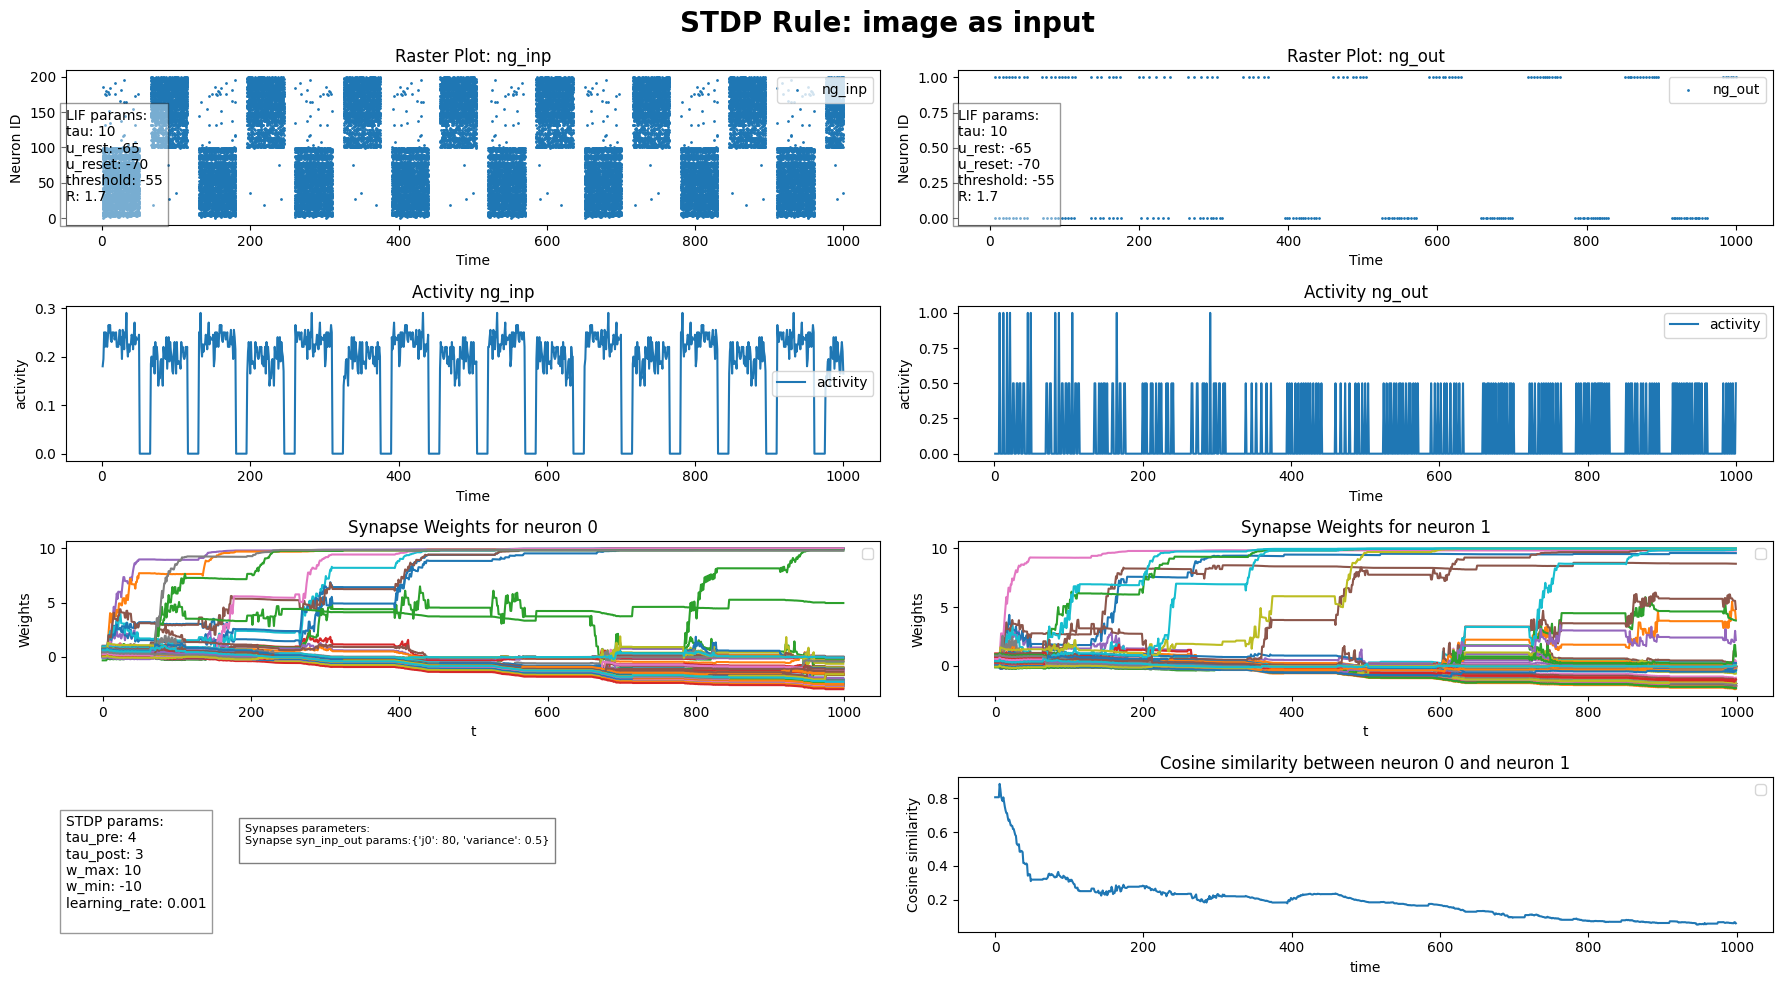

In [17]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: image as input", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-images-stdp.pdf")
plt.show()

### image with overlap

In [29]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.ones(50))),
                                          np.concatenate((np.ones(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37d638cc10>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


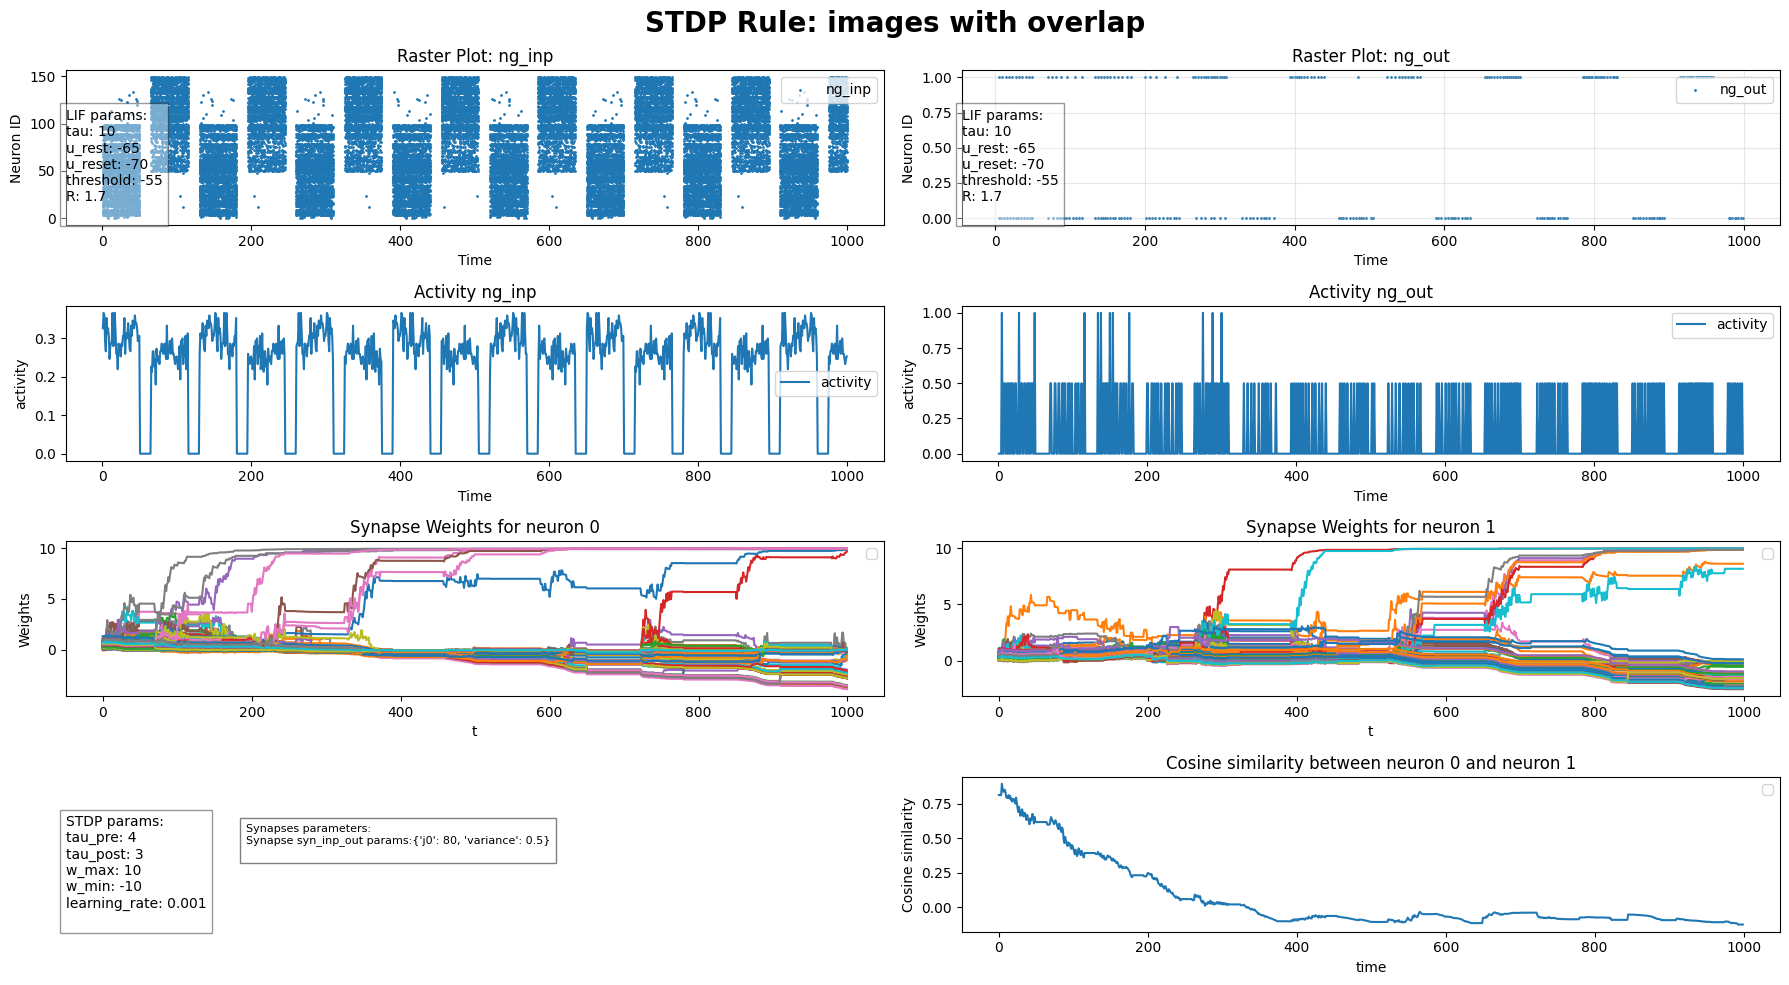

In [32]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: images with overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-images-stdp-overlap.pdf")
plt.show()

### image with high overlap

In [37]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.array(img1.img2tensor()),
                                          np.array(img2.img2tensor())],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     w_min=-10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37bd456610>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


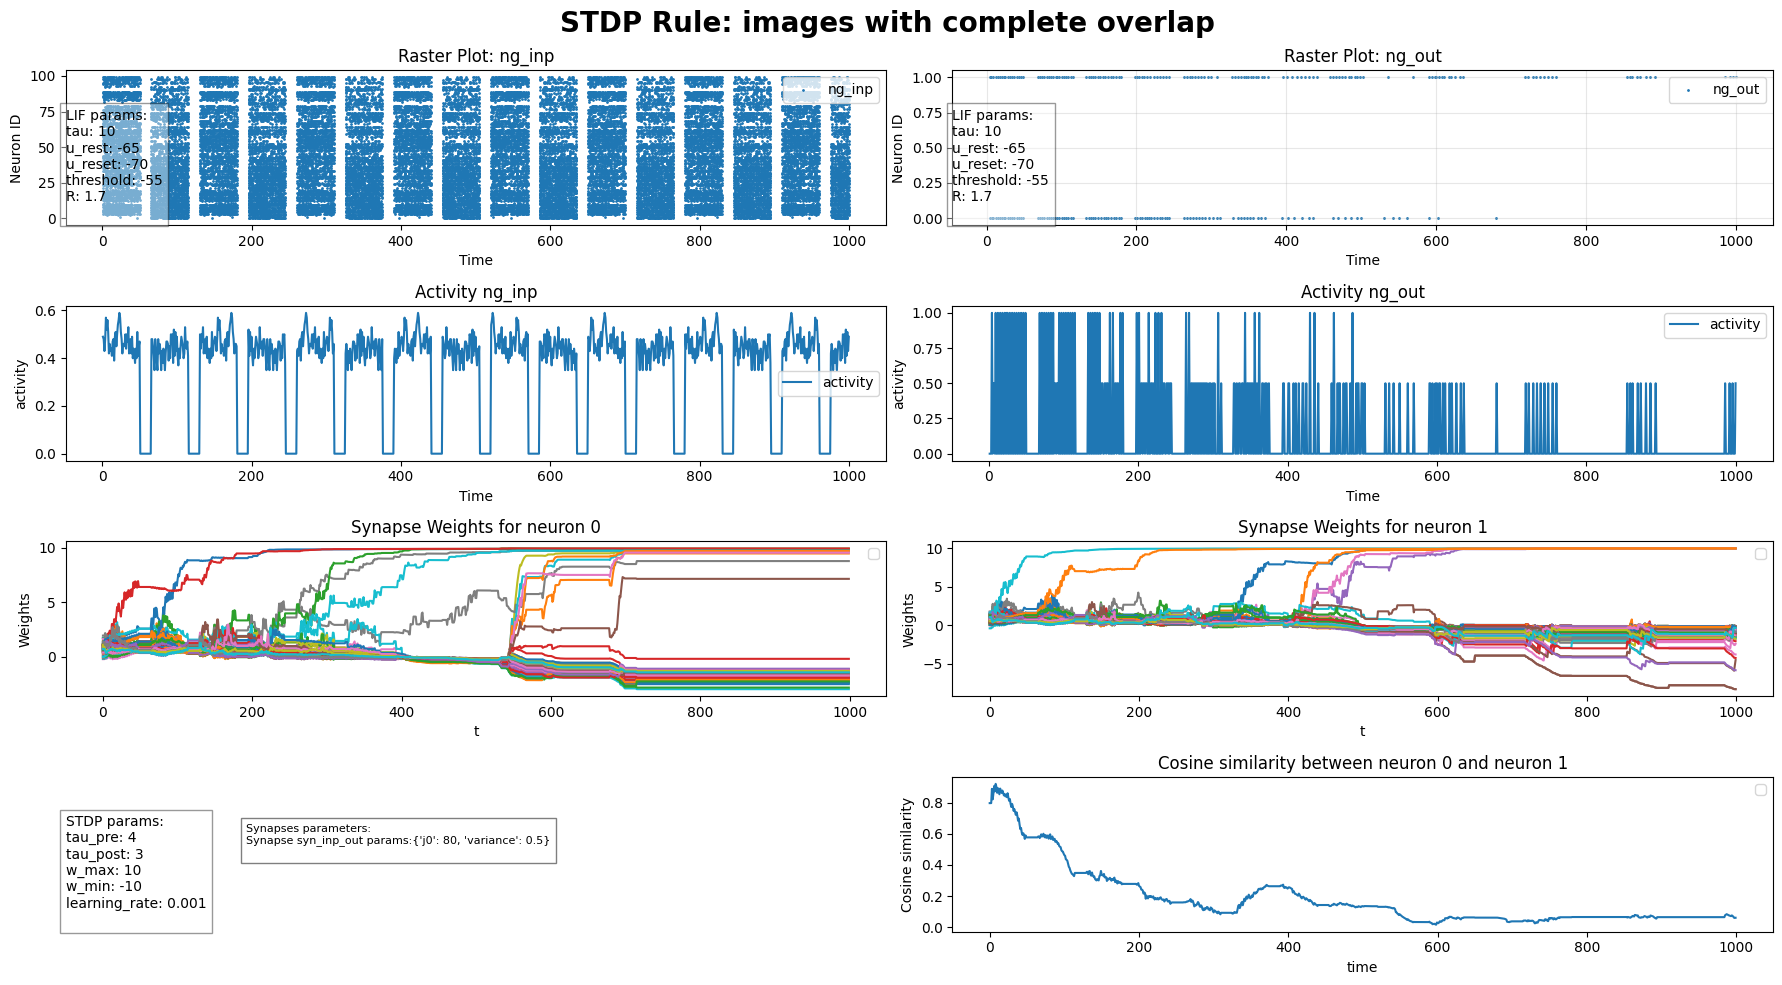

In [38]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule: images with complete overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-images-stdp-high-overlap.pdf")
plt.show()

## Change in initial weights

In [55]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out_low_weight = sim.add_neuron_group(
    tag="ng_out_low_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_low_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_low_weight_event")
    }
)
ng_out_norm_weight = sim.add_neuron_group(
    tag="ng_out_norm_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_norm_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_norm_weight_event")
    }
)
ng_out_high_weight = sim.add_neuron_group(
    tag="ng_out_high_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_high_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_high_weight_event")
    }
)
syn_inp_out_low = sim.add_synapse_group(
                   tag="syn_inp_out_low",
                   src=ng_inp,
                   dst=ng_out_low_weight,
                   behavior={3: FullyConnectedSynapse(j0=10,
                                                      variance=0.5),
                             7: STDP(tau_pre=4,
                                    tau_post=3,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_low_rec"),
                             },
)
syn_inp_out_norm = sim.add_synapse_group(
                   tag="syn_inp_out_norm",
                   src=ng_inp,
                   dst=ng_out_norm_weight,
                   behavior={3: FullyConnectedSynapse(j0=80,
                                                      variance=0.5),
                             7: STDP(tau_pre=4,
                                    tau_post=3,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_norm_rec"),
                             },
)
syn_inp_out_high = sim.add_synapse_group(
                   tag="syn_inp_out_high",
                   src=ng_inp,
                   dst=ng_out_high_weight,
                   behavior={3: FullyConnectedSynapse(j0=140,
                                                      variance=0.5),
                             7: STDP(tau_pre=4,
                                    tau_post=3,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_high_rec"),
                             },
)
sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(156)|4 groups, Synapses: tensor(900)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37bc400190>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out_low_weight', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_low_weight_rec,)10:EventRecorder(variables=['spike'],g

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

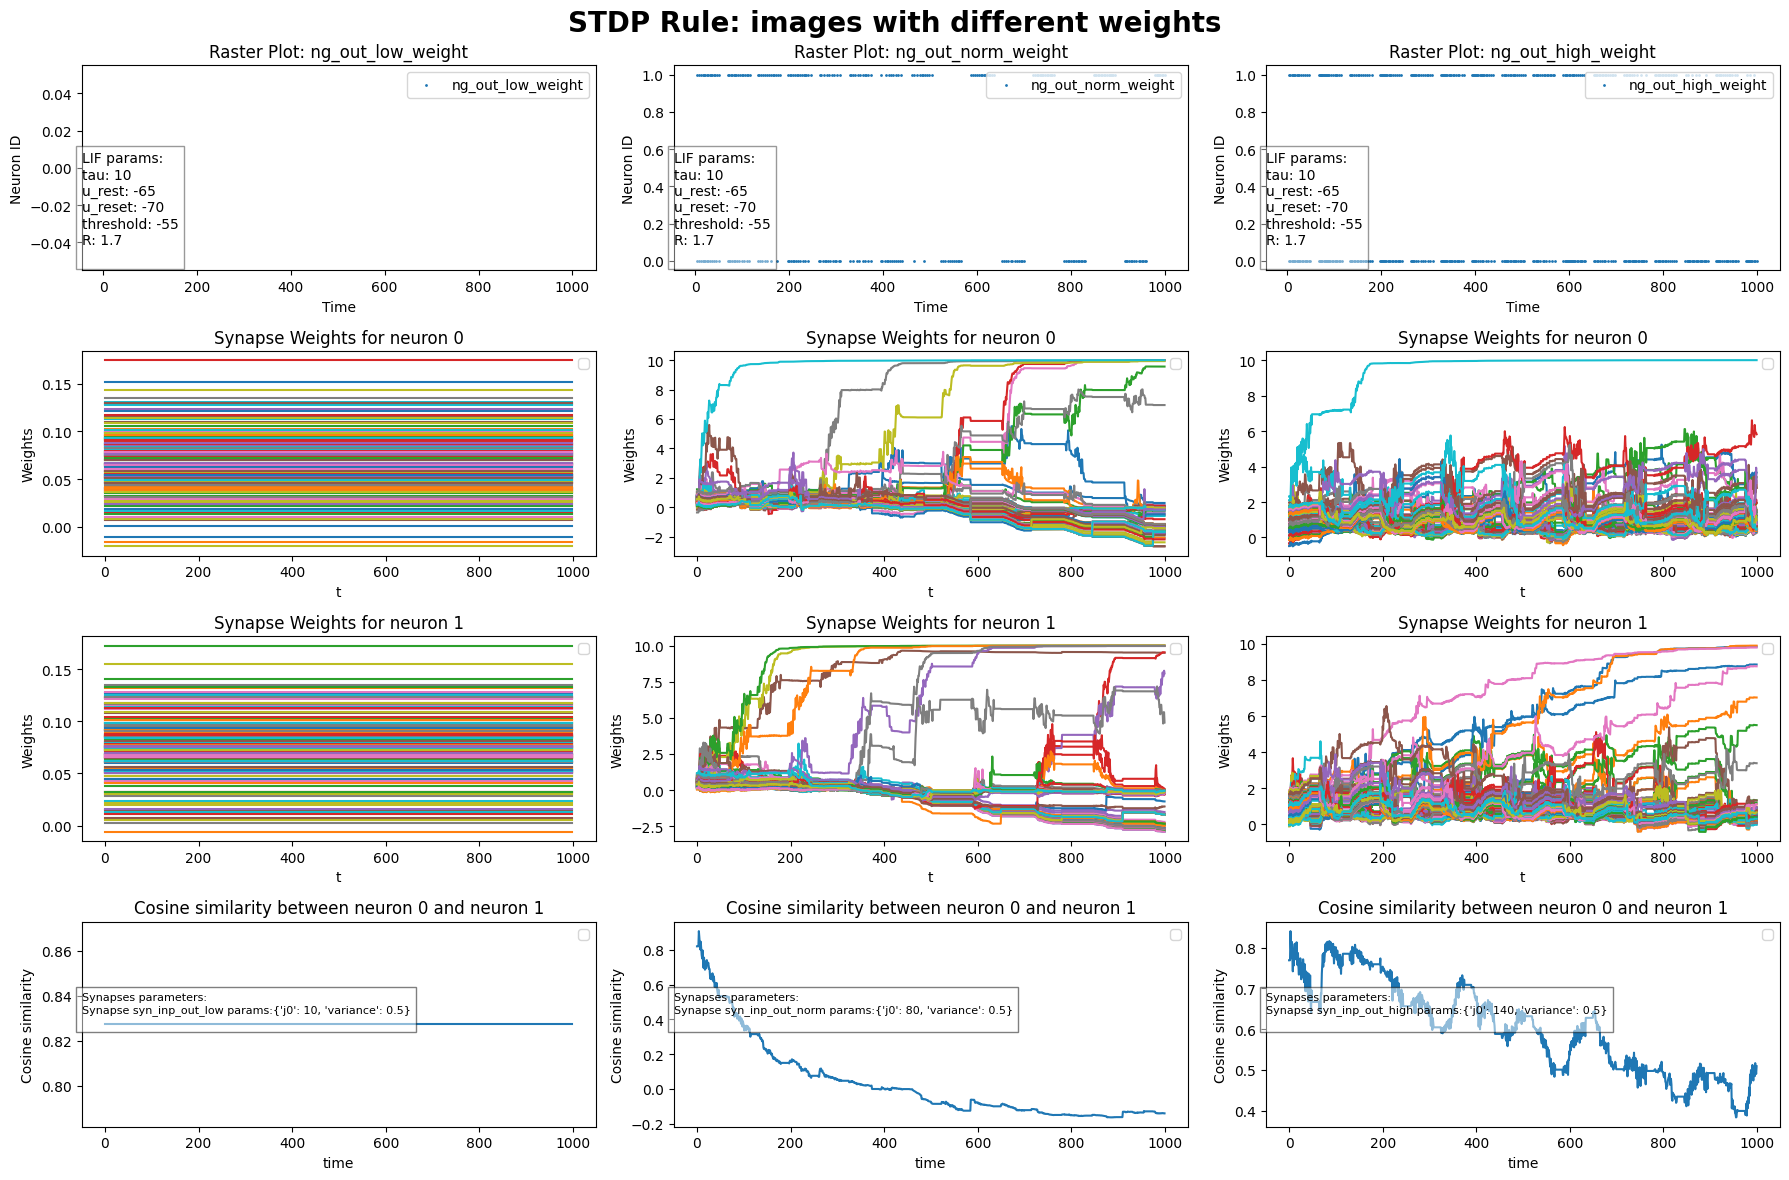

In [57]:
fig = plt.figure(figsize=(18, 12))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 3, 1)  # 3 rows, 1 column, first plot
ng_out_low_weight.add_raster_plot(ax1, s=1)
ng_out_low_weight.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 3, 2, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_norm_weight.add_raster_plot(ax2, s=1)
ng_out_norm_weight.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 3, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_high_weight.add_raster_plot(ax3, s=1)
ng_out_high_weight.add_neuron_model_params_info(ax3, model_idx=6)


ax4 = fig.add_subplot(4, 3, 4)
syn_inp_out_low.add_weights_plot(ax4, neuron_id=0)

ax5 = fig.add_subplot(4, 3, 5)
syn_inp_out_norm.add_weights_plot(ax5, neuron_id=0)

ax6 = fig.add_subplot(4, 3, 6)
syn_inp_out_high.add_weights_plot(ax6, neuron_id=0)

ax7 = fig.add_subplot(4, 3, 7)
syn_inp_out_low.add_weights_plot(ax7, neuron_id=1)

ax8 = fig.add_subplot(4, 3, 8)
syn_inp_out_norm.add_weights_plot(ax8, neuron_id=1)

ax9 = fig.add_subplot(4, 3, 9)
syn_inp_out_high.add_weights_plot(ax9, neuron_id=1)


ax10 = fig.add_subplot(4, 3, 10)
syn_inp_out_low.add_cosine_similarity_plot(ax10,neuron_1=0, neuron_2=1)
syn_inp_out_low.add_synapses_params_info(ax10, synapse_idx=3)

ax11 = fig.add_subplot(4, 3, 11)
syn_inp_out_norm.add_cosine_similarity_plot(ax11,neuron_1=0, neuron_2=1)
syn_inp_out_norm.add_synapses_params_info(ax11, synapse_idx=3)

ax12 = fig.add_subplot(4, 3, 12)
syn_inp_out_high.add_cosine_similarity_plot(ax12,neuron_1=0, neuron_2=1)
syn_inp_out_high.add_synapses_params_info(ax12, synapse_idx=3)


fig.suptitle("STDP Rule: images with different weights", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-images-stdp-different-weight.pdf")
plt.show()

## Change in tau_pre and tau_post

In [62]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out_low_weight = sim.add_neuron_group(
    tag="ng_out_low_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_low_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_low_weight_event")
    }
)
ng_out_norm_weight = sim.add_neuron_group(
    tag="ng_out_norm_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_norm_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_norm_weight_event")
    }
)
ng_out_high_weight = sim.add_neuron_group(
    tag="ng_out_high_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_high_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_high_weight_event")
    }
)
syn_inp_out_low = sim.add_synapse_group(
                   tag="syn_inp_out_low",
                   src=ng_inp,
                   dst=ng_out_low_weight,
                   behavior={3: FullyConnectedSynapse(j0=60,
                                                      variance=0.5),
                             7: STDP(tau_pre=1,
                                    tau_post=5,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_low_rec"),
                             },
)
syn_inp_out_norm = sim.add_synapse_group(
                   tag="syn_inp_out_norm",
                   src=ng_inp,
                   dst=ng_out_norm_weight,
                   behavior={3: FullyConnectedSynapse(j0=60,
                                                      variance=0.5),
                             7: STDP(tau_pre=5,
                                    tau_post=5,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_norm_rec"),
                             },
)
syn_inp_out_high = sim.add_synapse_group(
                   tag="syn_inp_out_high",
                   src=ng_inp,
                   dst=ng_out_high_weight,
                   behavior={3: FullyConnectedSynapse(j0=60,
                                                      variance=0.5),
                             7: STDP(tau_pre=5,
                                    tau_post=1,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_high_rec"),
                             },
)
sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(156)|4 groups, Synapses: tensor(900)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37bd5dd510>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out_low_weight', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_low_weight_rec,)10:EventRecorder(variables=['spike'],g

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

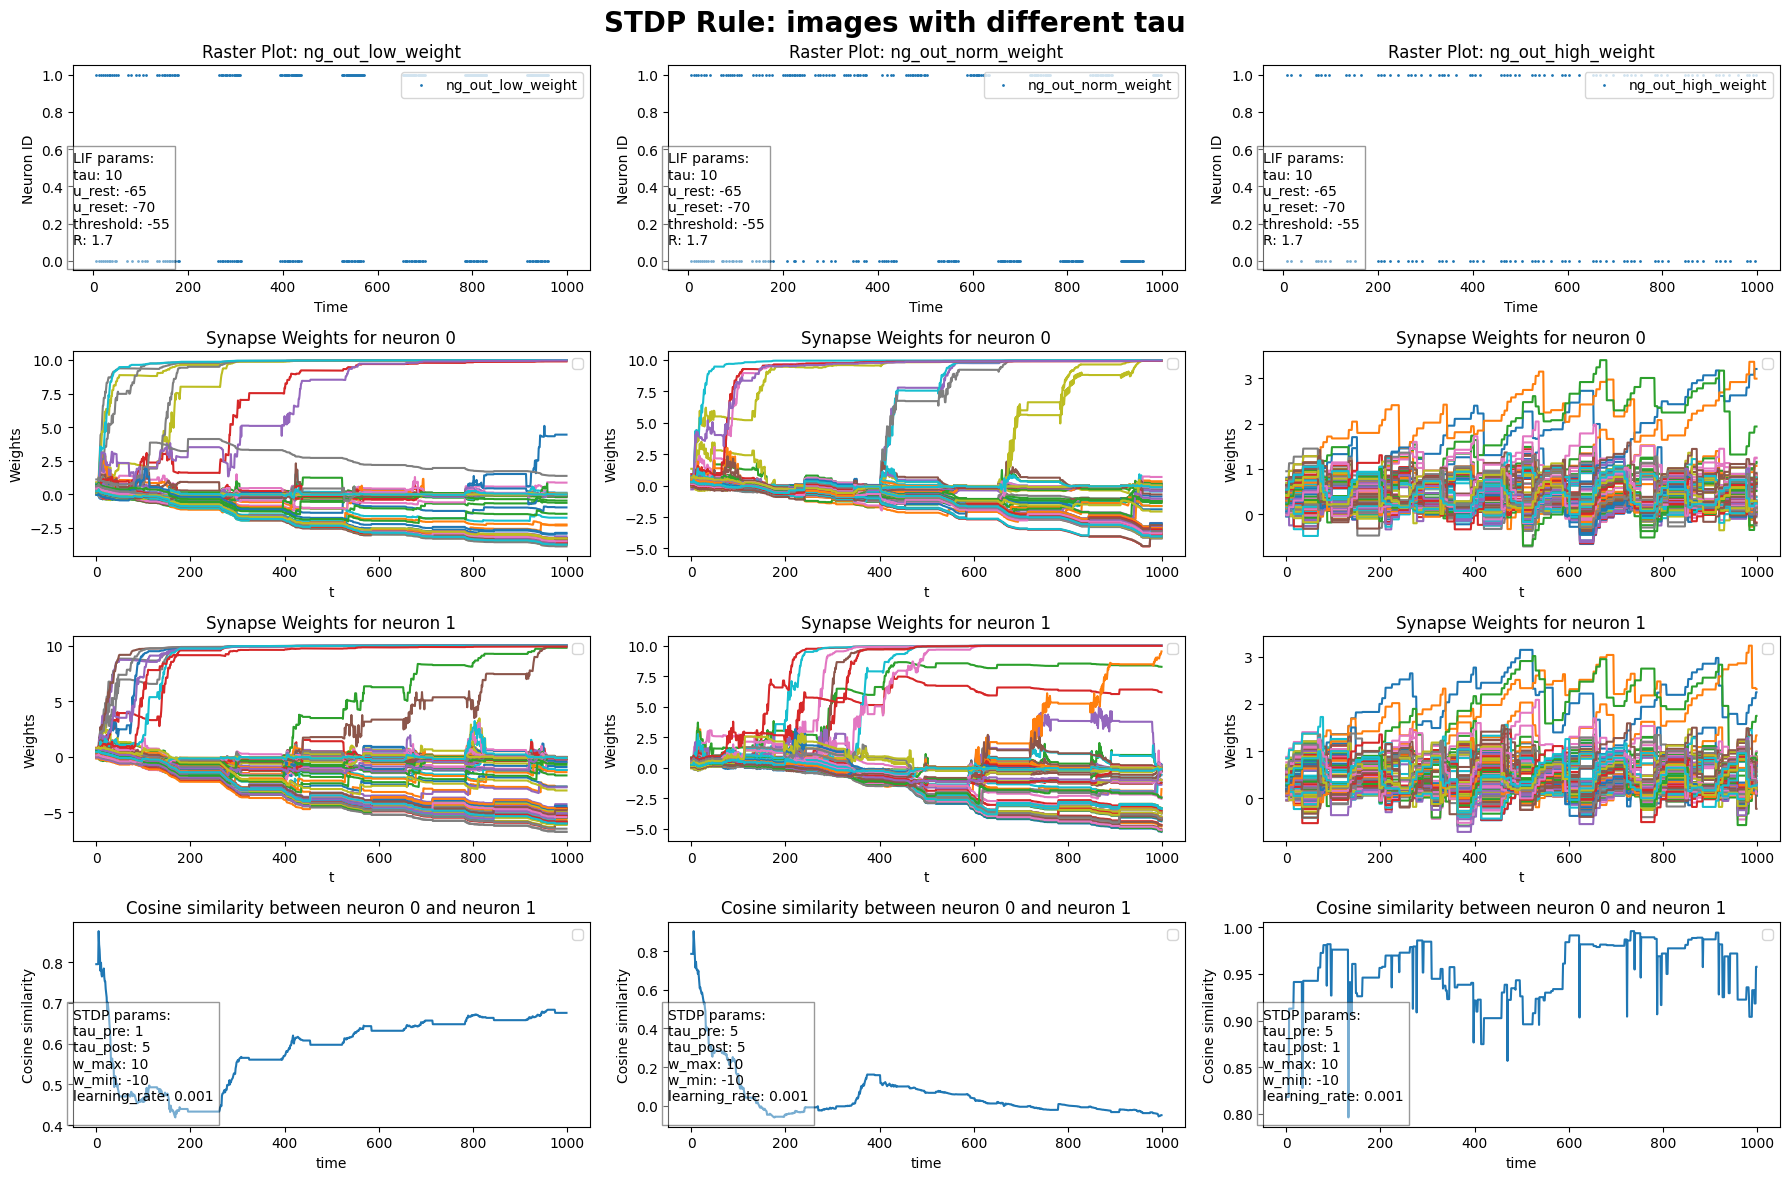

In [63]:
fig = plt.figure(figsize=(18, 12))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 3, 1)  # 3 rows, 1 column, first plot
ng_out_low_weight.add_raster_plot(ax1, s=1)
ng_out_low_weight.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 3, 2, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_norm_weight.add_raster_plot(ax2, s=1)
ng_out_norm_weight.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 3, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_high_weight.add_raster_plot(ax3, s=1)
ng_out_high_weight.add_neuron_model_params_info(ax3, model_idx=6)


ax4 = fig.add_subplot(4, 3, 4)
syn_inp_out_low.add_weights_plot(ax4, neuron_id=0)

ax5 = fig.add_subplot(4, 3, 5)
syn_inp_out_norm.add_weights_plot(ax5, neuron_id=0)

ax6 = fig.add_subplot(4, 3, 6)
syn_inp_out_high.add_weights_plot(ax6, neuron_id=0)

ax7 = fig.add_subplot(4, 3, 7)
syn_inp_out_low.add_weights_plot(ax7, neuron_id=1)

ax8 = fig.add_subplot(4, 3, 8)
syn_inp_out_norm.add_weights_plot(ax8, neuron_id=1)

ax9 = fig.add_subplot(4, 3, 9)
syn_inp_out_high.add_weights_plot(ax9, neuron_id=1)


ax10 = fig.add_subplot(4, 3, 10)
syn_inp_out_low.add_cosine_similarity_plot(ax10,neuron_1=0, neuron_2=1)
syn_inp_out_low.add_learning_params_info(ax10, synapse_idx=7)

ax11 = fig.add_subplot(4, 3, 11)
syn_inp_out_norm.add_cosine_similarity_plot(ax11,neuron_1=0, neuron_2=1)
syn_inp_out_norm.add_learning_params_info(ax11, synapse_idx=7)

ax12 = fig.add_subplot(4, 3, 12)
syn_inp_out_high.add_cosine_similarity_plot(ax12,neuron_1=0, neuron_2=1)
syn_inp_out_high.add_learning_params_info(ax12, synapse_idx=7)


fig.suptitle("STDP Rule: images with different tau", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-images-stdp-different-tau.pdf")
plt.show()

# Adding one neuron to input and output layer

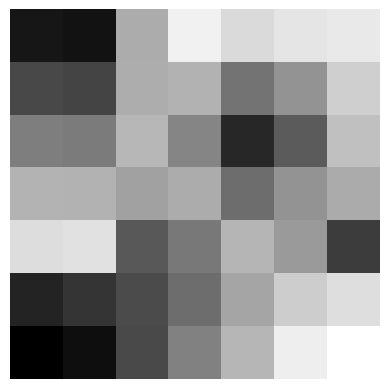

In [65]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(7,7)
img1.img_show()

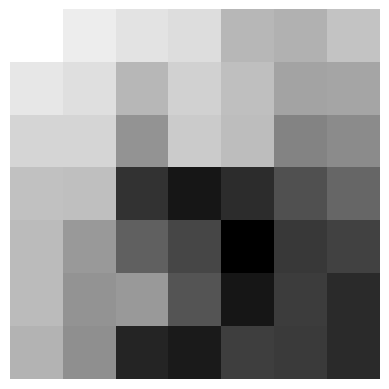

In [66]:
img2 = CustomImage('dataset/bird.tif')
img2.resize_image(7,7)
img2.img_show()

### using Weights to prevent added neuron to spike

In [71]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((img2.img2tensor(), np.zeros(1)))],
                                 duration=15,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=3,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: STDP(tau_pre=4,
                                    tau_post=3,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001
                                    ),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.initialize()
syn_inp_out.W[:, -1] = 0.0
sim.simulate_iterations(iterations=500)

Network['Network_1', 'Network'](Neurons: tensor(53)|2 groups, Synapses: tensor(150)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37d541eb10>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](3){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=No

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


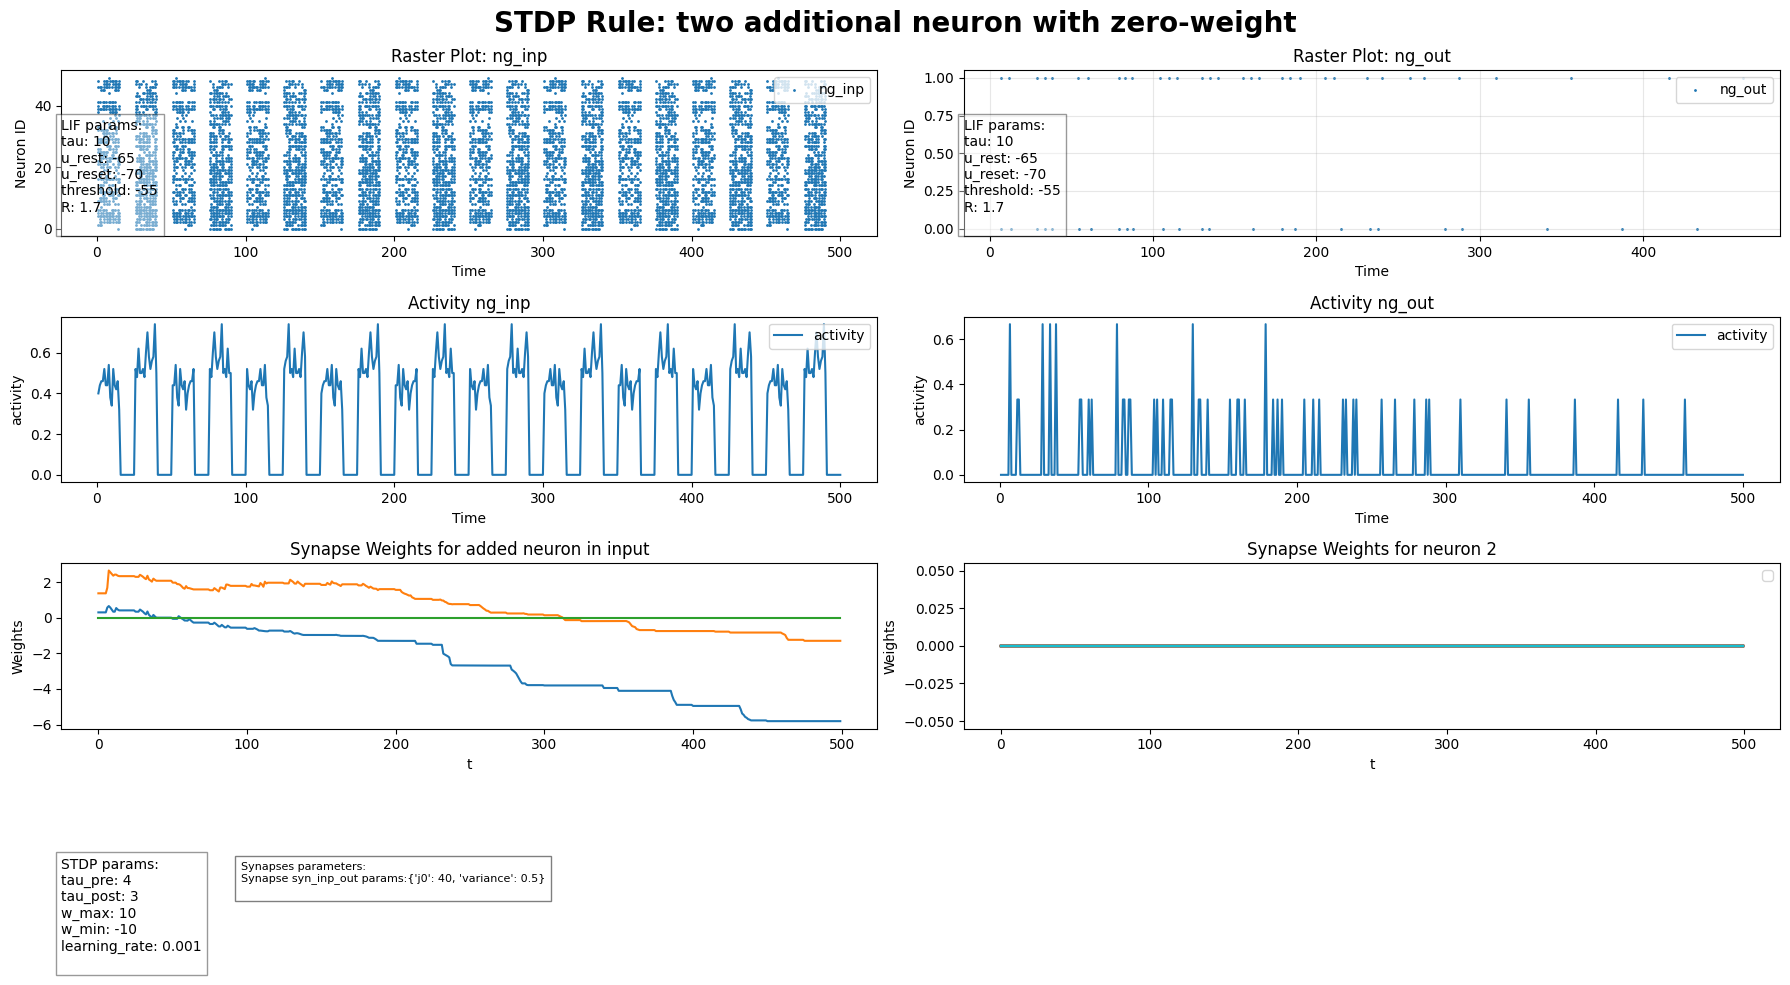

In [73]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)


ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)


ax5 = fig.add_subplot(4, 2, 5)
# syn_inp_out.add_weights_plot(ax5, neuron_id=0)
ax5.plot(syn_inp_out[f"syn_inp_out_rec", 0].variables["W"][:, -1, :])
ax5.set_xlabel('t')
ax5.set_ylabel('Weights')
ax5.set_title(f'Synapse Weights for added neuron in input')

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=2)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

fig.suptitle("STDP Rule: two additional neuron with zero-weight", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-stdp-two-additional-neuron-zero-weight.pdf")
plt.show()

### using threshold to prevent added neuron to spike

In [74]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((img2.img2tensor(), np.zeros(1)))],
                                 duration=15,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=3,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: STDP(tau_pre=4,
                                    tau_post=3,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.initialize()
ng_out.threshold[-1] = 100.0
sim.simulate_iterations(iterations=500)

Network['Network_1', 'Network'](Neurons: tensor(53)|2 groups, Synapses: tensor(150)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37d632d0d0>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](3){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=No

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


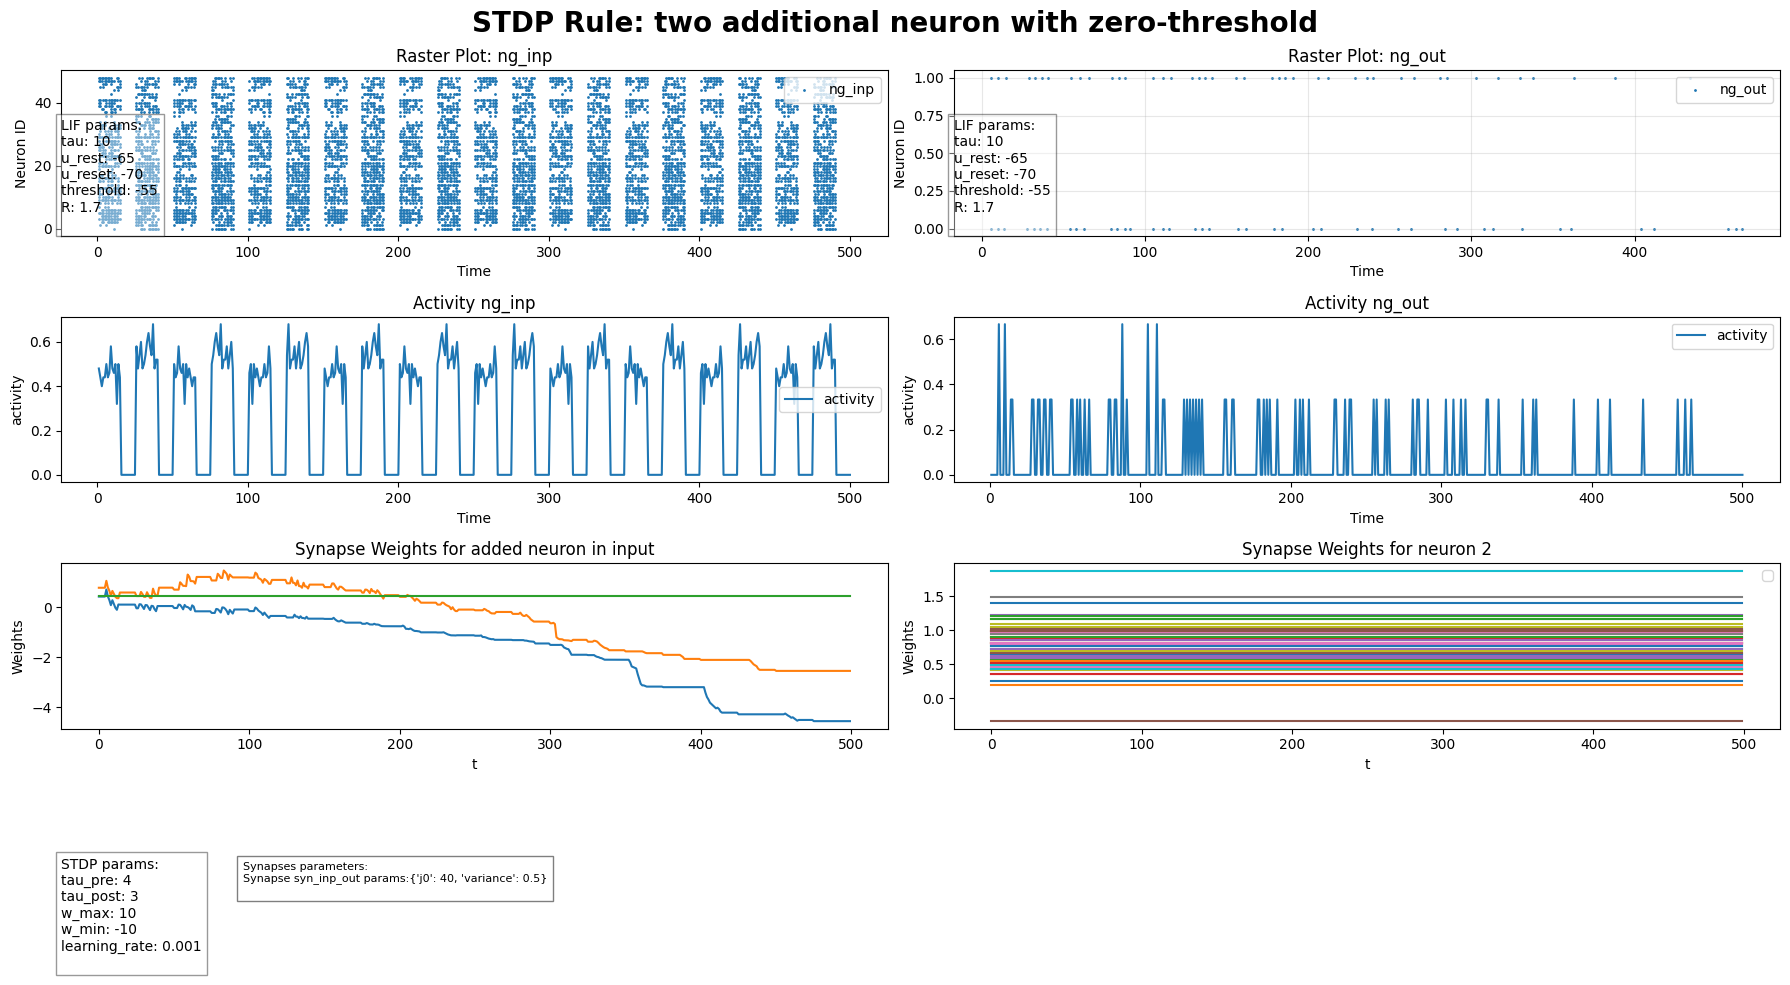

In [75]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)


ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)


ax5 = fig.add_subplot(4, 2, 5)
# syn_inp_out.add_weights_plot(ax5, neuron_id=0)
ax5.plot(syn_inp_out[f"syn_inp_out_rec", 0].variables["W"][:, -1, :])
ax5.set_xlabel('t')
ax5.set_ylabel('Weights')
ax5.set_title(f'Synapse Weights for added neuron in input')

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=2)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

fig.suptitle("STDP Rule: two additional neuron with zero-threshold", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-stdp-two-additional-neuron-zero-threshold.pdf")
plt.show()

### with normalization off

In [76]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((img2.img2tensor(), np.zeros(1)))],
                                 duration=15,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=3,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: STDP(tau_pre=4,
                                    tau_post=3,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    normalization=False),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.initialize()
ng_out.threshold[-1] = 100.0
sim.simulate_iterations(iterations=500)

Network['Network_1', 'Network'](Neurons: tensor(53)|2 groups, Synapses: tensor(150)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37b6f153d0>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](3){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=No

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


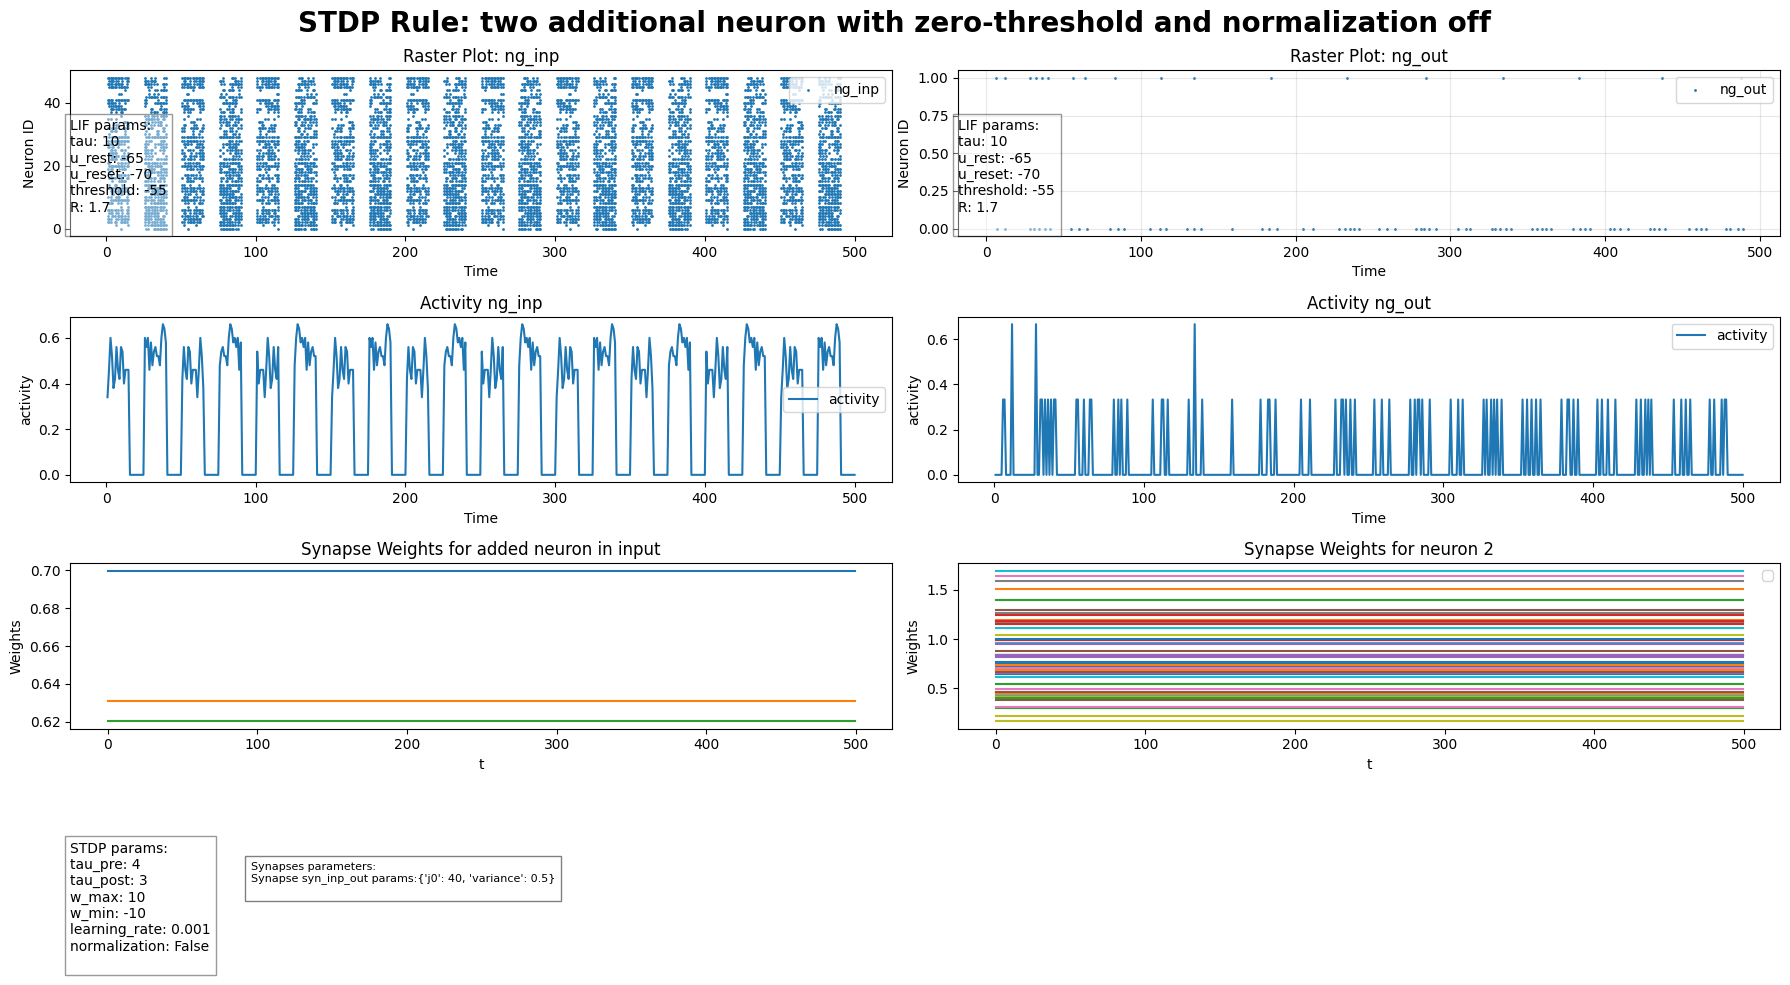

In [78]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)


ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)


ax5 = fig.add_subplot(4, 2, 5)
# syn_inp_out.add_weights_plot(ax5, neuron_id=0)
ax5.plot(syn_inp_out[f"syn_inp_out_rec", 0].variables["W"][:, -1, :])
ax5.set_xlabel('t')
ax5.set_ylabel('Weights')
ax5.set_title(f'Synapse Weights for added neuron in input')

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=2)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

fig.suptitle("STDP Rule: two additional neuron with zero-threshold and normalization off", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-stdp-two-additional-neuron-zero-threshold-norm-off.pdf")
plt.show()

# Background Activity

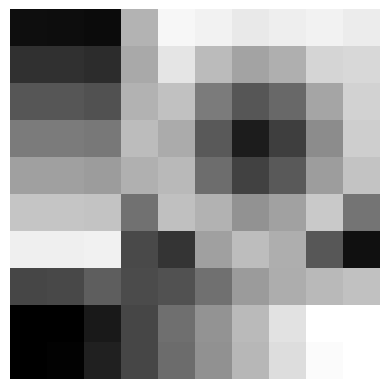

In [88]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(10, 10)
img1.img_show()

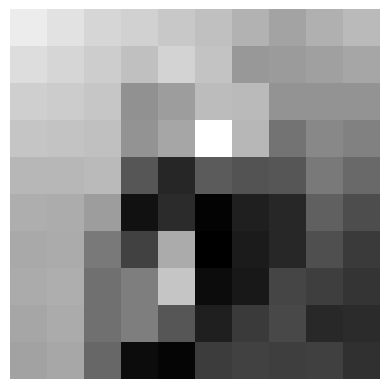

In [89]:
img2 = CustomImage('dataset/bird.tif')
img2.resize_image(10, 10)
img2.img_show()

In [90]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=1, noise_range=0.5),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=1, noise_range=0.5),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: STDP(tau_pre=4,
                       tau_post=3,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=1,noise_range=0.5,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37d56fb510>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=1,noise_range=0.5,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=[

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


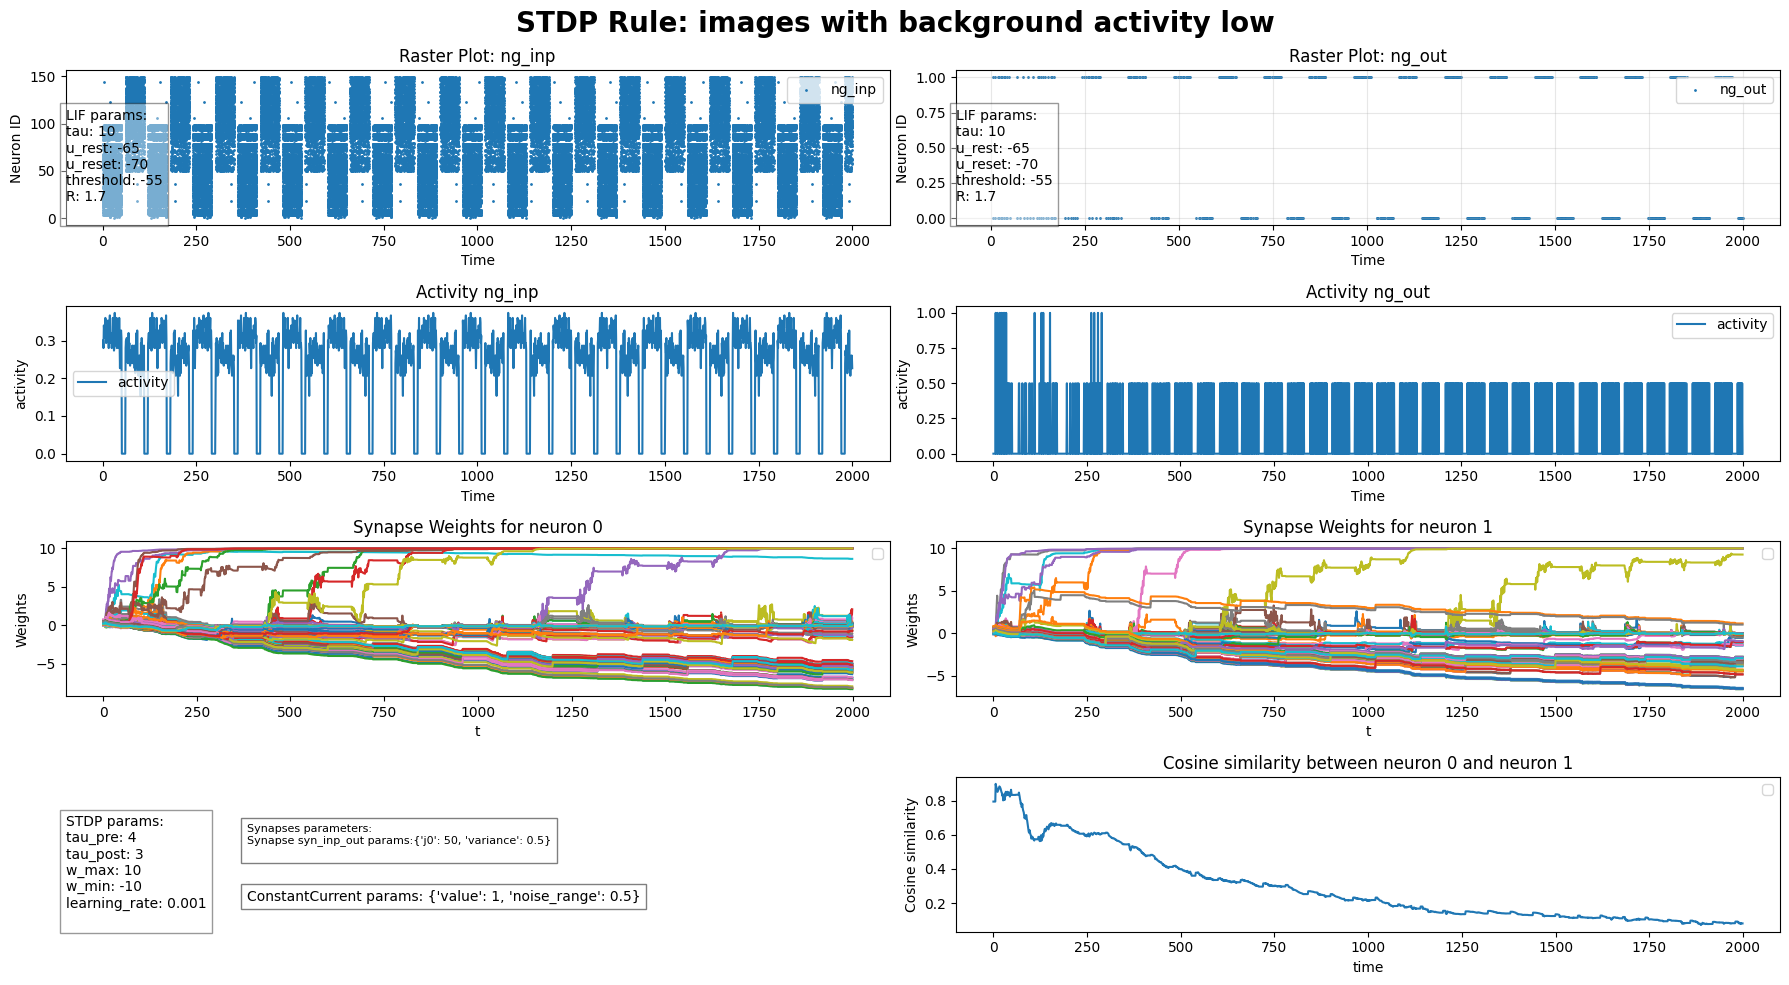

In [91]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)
ng_inp.add_current_params_info(ax7, current_idx=2, text_x=0.22, text_y=0.2)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("STDP Rule: images with background activity low", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-stdp-images-background-activity-low.pdf")
plt.show()

### more background activity

In [92]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=4, noise_range=0.5),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=4, noise_range=0.5),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: STDP(tau_pre=4,
                       tau_post=3,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=4,noise_range=0.5,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37b6d4ae90>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=4,noise_range=0.5,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=[

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


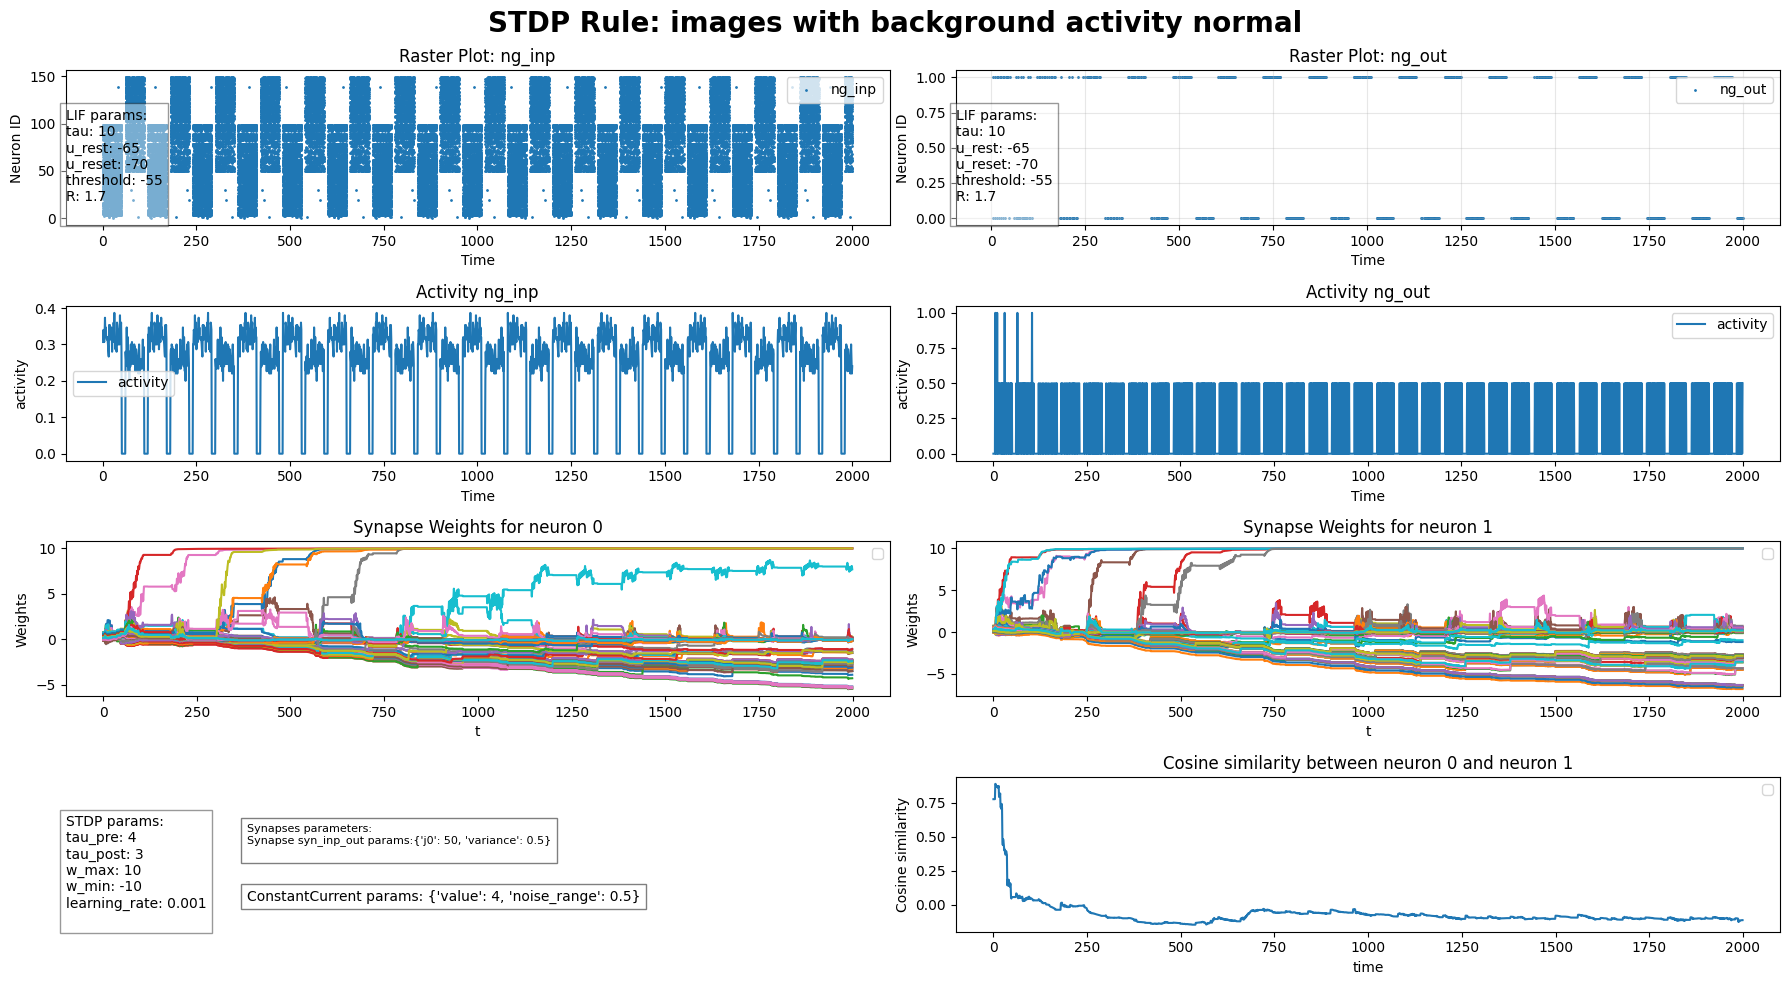

In [93]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)
ng_inp.add_current_params_info(ax7, current_idx=2, text_x=0.22, text_y=0.2)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("STDP Rule: images with background activity normal", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-stdp-images-background-activity-norm.pdf")
plt.show()

### high background activity

In [94]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=13.2, noise_range=0.5),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=13.2, noise_range=0.5),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: STDP(tau_pre=4,
                       tau_post=3,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=13.2,noise_range=0.5,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7f37b6e8d210>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=13.2,noise_range=0.5,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(varia

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


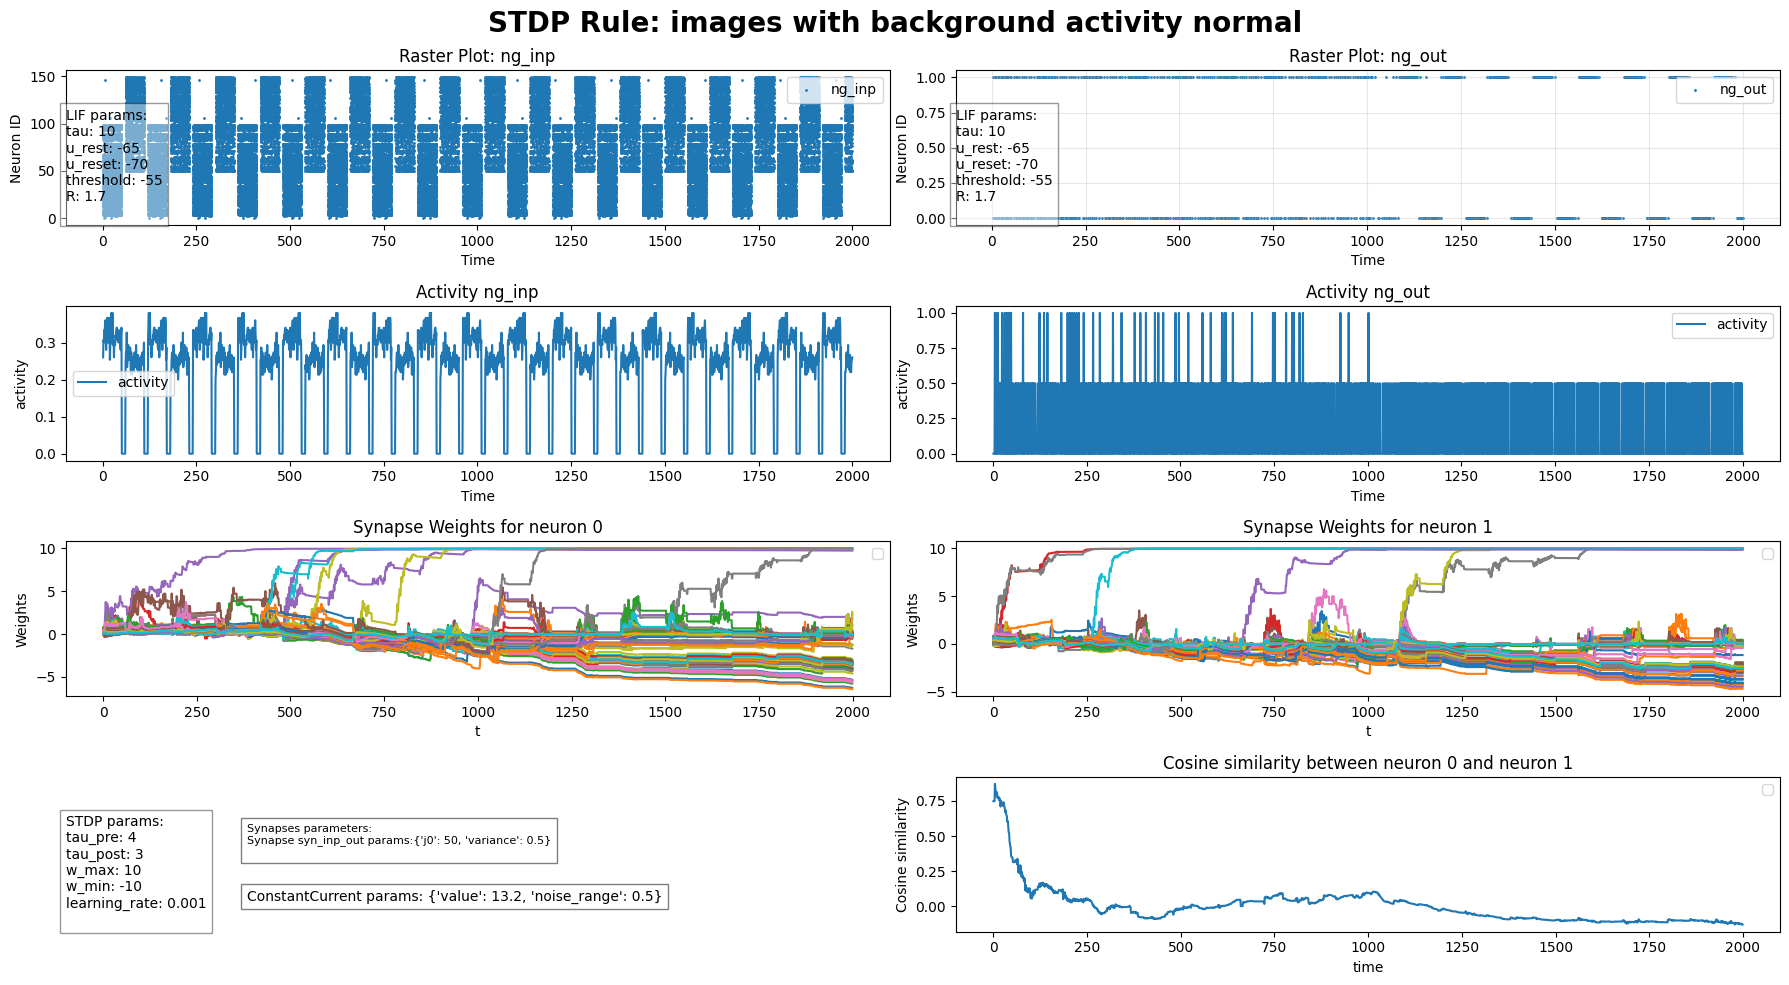

In [95]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
ng_out.add_raster_plot(ax2, s=1)
ng_out.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)
ng_inp.add_current_params_info(ax7, current_idx=2, text_x=0.22, text_y=0.2)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("STDP Rule: images with background activity normal", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-stdp-images-background-activity-high.pdf")
plt.show()